In [21]:
!pip install keras

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

In [23]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

In [24]:
from keras.models import Sequential, Model
from keras.layers import Input, Conv2D, MaxPooling2D, Dense, Reshape, Flatten, Multiply, Dropout, Lambda, GlobalAveragePooling2D
from keras.optimizers import Adam

def squeeze_block(x, filter_num, block_number):
    squeeze = GlobalAveragePooling2D()(x)
    squeeze = Dense(int(filter_num / 2), activation="relu", kernel_initializer="he_normal")(squeeze)

    squeeze = Dense(filter_num, activation="sigmoid", kernel_initializer="he_normal",
                    name=f"squeeze_coef_{block_number}")(squeeze)
    squeeze = Reshape((1, 1, filter_num))(squeeze)
    c = Multiply()([x, squeeze])
    return c

def model_gen():
    print("Building model ...")
    inputs = Input((28, 28, 1))

    c = Conv2D(filters=16, kernel_size=(3, 3), strides=(1, 1), padding="same",
               kernel_initializer="he_normal", activation="relu", name="conv_before_squeeze")(inputs)
    c = squeeze_block(c, 16, block_number=1)
    c = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same")(c)

    c = Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding="same",
               kernel_initializer="he_normal", activation='relu', name="conv_after_squeeze")(c)
    c = squeeze_block(c, 32, block_number=2)
    c = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same")(c)

    f = Flatten()(c)
    d = Dense(64, activation="relu", kernel_initializer="he_normal")(f)
    d = Dropout(rate=0.5)(d)
    outputs = Dense(10, activation="softmax", kernel_initializer="he_normal")(d)  # Output layer for 10 classes

    model = Model(inputs=[inputs], outputs=[outputs])
    optim = Adam(learning_rate=0.005)
    model.compile(loss="categorical_crossentropy", optimizer=optim, metrics=['accuracy'])  # Use categorical_crossentropy for classification

    return model

model = model_gen()
model.summary()

Building model ...
Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_10 (InputLayer)       [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv_before_squeeze (Conv2  (None, 28, 28, 16)           160       ['input_10[0][0]']            
 D)                                                                                               
                                                                                                  
 global_average_pooling2d_1  (None, 16)                   0         ['conv_before_squeeze[0][0]'] 
 8 (GlobalAveragePooling2D)                                                                       
                                                                         

In [25]:
import numpy as np
from sklearn.model_selection import KFold

kf = KFold(n_splits=3, shuffle=True, random_state=42)

X_series = []
y_series = []
for train_index, val_index in kf.split(x_train):
    X_series.append(x_train[train_index])
    y_series.append(y_train[train_index])
X_test = x_test
input_len = (28, 28, 1)
batch_size = 50
epochs_number = 30

In [26]:
def step_decay(epoch):
    initial_lrate = 0.005
    drop = 0.8
    epochs_drop = 5.0
    lrate = initial_lrate * np.power(drop, np.floor((1 + epoch) / epochs_drop))
    return lrate


In [27]:
print("Length of X_series:", len(X_series))
print("Length of y_series:", len(y_series))


Length of X_series: 3
Length of y_series: 3


In [28]:
from tensorflow.keras.callbacks import LearningRateScheduler

lrate = LearningRateScheduler(step_decay)
y_test_predictions = []

for i in range(3):
    model = model_gen()
    X_fit, y_fit = None, None
    for j in range(3):
        if j != i:
            if X_fit is None:
                X_fit, y_fit = X_series[j], y_series[j]
            else:
                X_fit = np.concatenate((X_fit, X_series[j]), axis=0)
                y_fit = np.concatenate((y_fit, y_series[j]), axis=0)

    X_val, y_val = X_series[i], y_series[i]


    model.fit(X_fit, y_fit, batch_size=batch_size, epochs=epochs_number,
              validation_data=(X_val, y_val), shuffle=True, callbacks=[lrate])
    model_loss = np.zeros((5,), dtype=np.float32)
    y_pred_series = []

    model_loss[i] = model.evaluate(X_val, y_val)[0]
    pred = model.predict(X_val)
    y_pred_series.append(pred)

    y_test_predictions.append(model.predict(X_test))

if y_test_predictions:
    y_test_ensemble = np.mean(y_test_predictions, axis=0)

model.save_weights(filepath="model_param.hdf5")

model_loss_mean = np.mean(model_loss)
model_loss_std = np.std(model_loss)
print("CV Score for the model is {:.3f} +/- {:.3f}".format(model_loss_mean, model_loss_std))


Building model ...
Epoch 1/30
1600/1600 [==============================] - 23s 12ms/step - loss: 2.4426 - accuracy: 0.2167 - val_loss: 1.6684 - val_accuracy: 0.3641 - lr: 0.0050
Epoch 2/30
1600/1600 [==============================] - 12s 7ms/step - loss: 1.8660 - accuracy: 0.2762 - val_loss: 1.2357 - val_accuracy: 0.5814 - lr: 0.0050
Epoch 3/30
1600/1600 [==============================] - 12s 7ms/step - loss: 1.2448 - accuracy: 0.5303 - val_loss: 0.2633 - val_accuracy: 0.9376 - lr: 0.0050
Epoch 4/30
1600/1600 [==============================] - 12s 7ms/step - loss: 0.7354 - accuracy: 0.7379 - val_loss: 0.1723 - val_accuracy: 0.9588 - lr: 0.0050
Epoch 5/30
1600/1600 [==============================] - 14s 9ms/step - loss: 0.5610 - accuracy: 0.8161 - val_loss: 0.1429 - val_accuracy: 0.9661 - lr: 0.0040
Epoch 6/30
1600/1600 [==============================] - 14s 9ms/step - loss: 0.4714 - accuracy: 0.8487 - val_loss: 0.1377 - val_accuracy: 0.9637 - lr: 0.0040
Epoch 7/30
1600/1600 [==========

Aplicando un kfold = 3, con 30 epocas de entrenamiento. Obtenemos una media de la perdida de 0.46 y una desviación estandar en 0.921 Estos son valores muy altos para estas métricas de evaluación. Esto puede deberse a diversos factores como la alta variabilidad de los datos o la arquitectura de nuestro modelo. Buscando mejores resultados, aplicaremos técnicas de regularización así como modificar los hiperparámetro del modelo.

In [30]:
from keras.regularizers import l1_l2
from keras.layers import BatchNormalization

def squeeze_block(x, filter_num, block_number):

    squeeze = GlobalAveragePooling2D()(x)
    squeeze = Dense(int(filter_num / 2), activation="relu", kernel_initializer="he_normal",
                    kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(squeeze)


    squeeze = Dense(filter_num, activation="sigmoid", kernel_initializer="he_normal",
                    name=f"squeeze_coef_{block_number}")(squeeze)
    squeeze = Reshape((1, 1, filter_num))(squeeze)
    c = Multiply()([x, squeeze])
    return c

def model_gen():
    print("Building model ...")
    inputs = Input((28, 28, 1))

    c = Conv2D(filters=16, kernel_size=(3, 3), strides=(1, 1), padding="same",
               kernel_initializer="he_normal", activation="relu", name="conv_before_squeeze")(inputs)
    c = BatchNormalization()(c)
    c = squeeze_block(c, 16, block_number=1)
    c = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same")(c)

    c = Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding="same",
               kernel_initializer="he_normal", activation='relu', name="conv_after_squeeze")(c)
    c = BatchNormalization()(c)
    c = squeeze_block(c, 32, block_number=2)
    c = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same")(c)

    f = Flatten()(c)
    d = Dense(64, activation="relu", kernel_initializer="he_normal",
              kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(f)
    d = Dropout(rate=0.5)(d)
    outputs = Dense(10, activation="softmax", kernel_initializer="he_normal")(d)  # Output layer for 10 classes

    model = Model(inputs=[inputs], outputs=[outputs])
    optim = Adam(learning_rate=0.005)
    model.compile(loss="categorical_crossentropy", optimizer=optim, metrics=['accuracy'])  # Use categorical_crossentropy for classification

    return model

model = model_gen()
model.summary()

Building model ...
Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_15 (InputLayer)       [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv_before_squeeze (Conv2  (None, 28, 28, 16)           160       ['input_15[0][0]']            
 D)                                                                                               
                                                                                                  
 batch_normalization (Batch  (None, 28, 28, 16)           64        ['conv_before_squeeze[0][0]'] 
 Normalization)                                                                                   
                                                                        

In [31]:
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping


early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
lrate = LearningRateScheduler(step_decay)

y_test_predictions = []

for i in range(3):
    model = model_gen()
    X_fit, y_fit = None, None
    for j in range(3):
        if j != i:
            if X_fit is None:
                X_fit, y_fit = X_series[j], y_series[j]
            else:
                X_fit = np.concatenate((X_fit, X_series[j]), axis=0)
                y_fit = np.concatenate((y_fit, y_series[j]), axis=0)


    X_val, y_val = X_series[i], y_series[i]

    model.fit(X_fit, y_fit, batch_size=batch_size, epochs=epochs_number,
              validation_data=(X_val, y_val), shuffle=True, callbacks=[lrate, early_stopping])
    model_loss = np.zeros((5,), dtype=np.float32)
    y_pred_series = []
    model_loss[i] = model.evaluate(X_val, y_val)[0]
    pred = model.predict(X_val)
    y_pred_series.append(pred)

    y_test_predictions.append(model.predict(X_test))

if y_test_predictions:
    y_test_ensemble = np.mean(y_test_predictions, axis=0)

model.save_weights(filepath="model_param.hdf5")

model_loss_mean = np.mean(model_loss)
model_loss_std = np.std(model_loss)
print("CV Score for the model is {:.3f} +/- {:.3f}".format(model_loss_mean, model_loss_std))


Building model ...
Epoch 1/30
1600/1600 [==============================] - 18s 9ms/step - loss: 0.3659 - accuracy: 0.9077 - val_loss: 0.1468 - val_accuracy: 0.9837 - lr: 0.0050
Epoch 2/30
1600/1600 [==============================] - 14s 9ms/step - loss: 0.2077 - accuracy: 0.9654 - val_loss: 0.1379 - val_accuracy: 0.9871 - lr: 0.0050
Epoch 3/30
1600/1600 [==============================] - 14s 8ms/step - loss: 0.1883 - accuracy: 0.9719 - val_loss: 0.1344 - val_accuracy: 0.9861 - lr: 0.0050
Epoch 4/30
1600/1600 [==============================] - 16s 10ms/step - loss: 0.1766 - accuracy: 0.9750 - val_loss: 0.1273 - val_accuracy: 0.9883 - lr: 0.0050
Epoch 5/30
1600/1600 [==============================] - 13s 8ms/step - loss: 0.1531 - accuracy: 0.9785 - val_loss: 0.1036 - val_accuracy: 0.9910 - lr: 0.0040
Epoch 6/30
1600/1600 [==============================] - 14s 8ms/step - loss: 0.1454 - accuracy: 0.9799 - val_loss: 0.1090 - val_accuracy: 0.9902 - lr: 0.0040
Epoch 7/30
1600/1600 [==========

Igual al modelo anterior, aplicando un kfold = 3, con 30 epocas de entrenamiento. Obtenemos una media de la perdida de 0.008 y una desviación estandar de +- 0.015 Estos son valores muy favorables para el modelo. Sin embargo, tenemos un acurracy que va de 0.9924 a 0.9982. Los cambios realizados desde el modelo anterior consisten en la integración de la regularización a nuestra aqruitectura, en cada una de las capas densas. De manera similar agregamos dos capas de BatchNormalization tras cada una de las capas convolucionales. Por último hemos agregado un Earlystopping para el entrenamiento del modelo con una paciencia de 10, sin emabrgo no lo hemos visto entrar en acción en ninguno de los folds y en al menos 30 epocas.

Como mejoras a un tercer modelo, aplicariamos un aumento de los datos rotando las imagenes, volteandolas o realizando transformaciones, de esta manera, nuestro modelo podra entrenar sobre imagenes 'nuevas'. Revisar la arquitectura y considerar hacerla menos compleja en busqueda de reducir el sobreajuste que hemos notado. De igual manera reducir los parametros del early stopping para verlo en acción y corroborar si esto nos ayudará en entrenar este modelo de mejor manera.

1/1 [==============================] - 0s 43ms/step


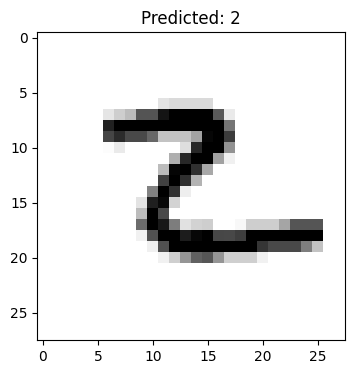

In [37]:
import random

index = random.randint(0, len(X_val) - 1)
selected_image = X_val[index]
selected_image_for_prediction = np.expand_dims(selected_image, axis=0)
predicted_label = model.predict(selected_image_for_prediction)
predicted_label = np.argmax(predicted_label, axis=1)[0]  plt.figure(figsize=(4, 4))
plt.imshow(selected_image, cmap=plt.cm.binary)
plt.title(f"Predicted: {predicted_label}")
plt.show()

In [38]:
def display_image_predictions(images, true_labels, predicted_labels, num_images=10):
    num_images = min(num_images, len(images))
    plt.figure(figsize=(15, 15))
    for i in range(num_images):
        plt.subplot(5, 5, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)

        plt.imshow(images[i], cmap=plt.cm.binary)

        plt.xlabel(f"Predicted: {predicted_labels[i]}")
    plt.show()


313/313 [==============================] - 1s 5ms/step


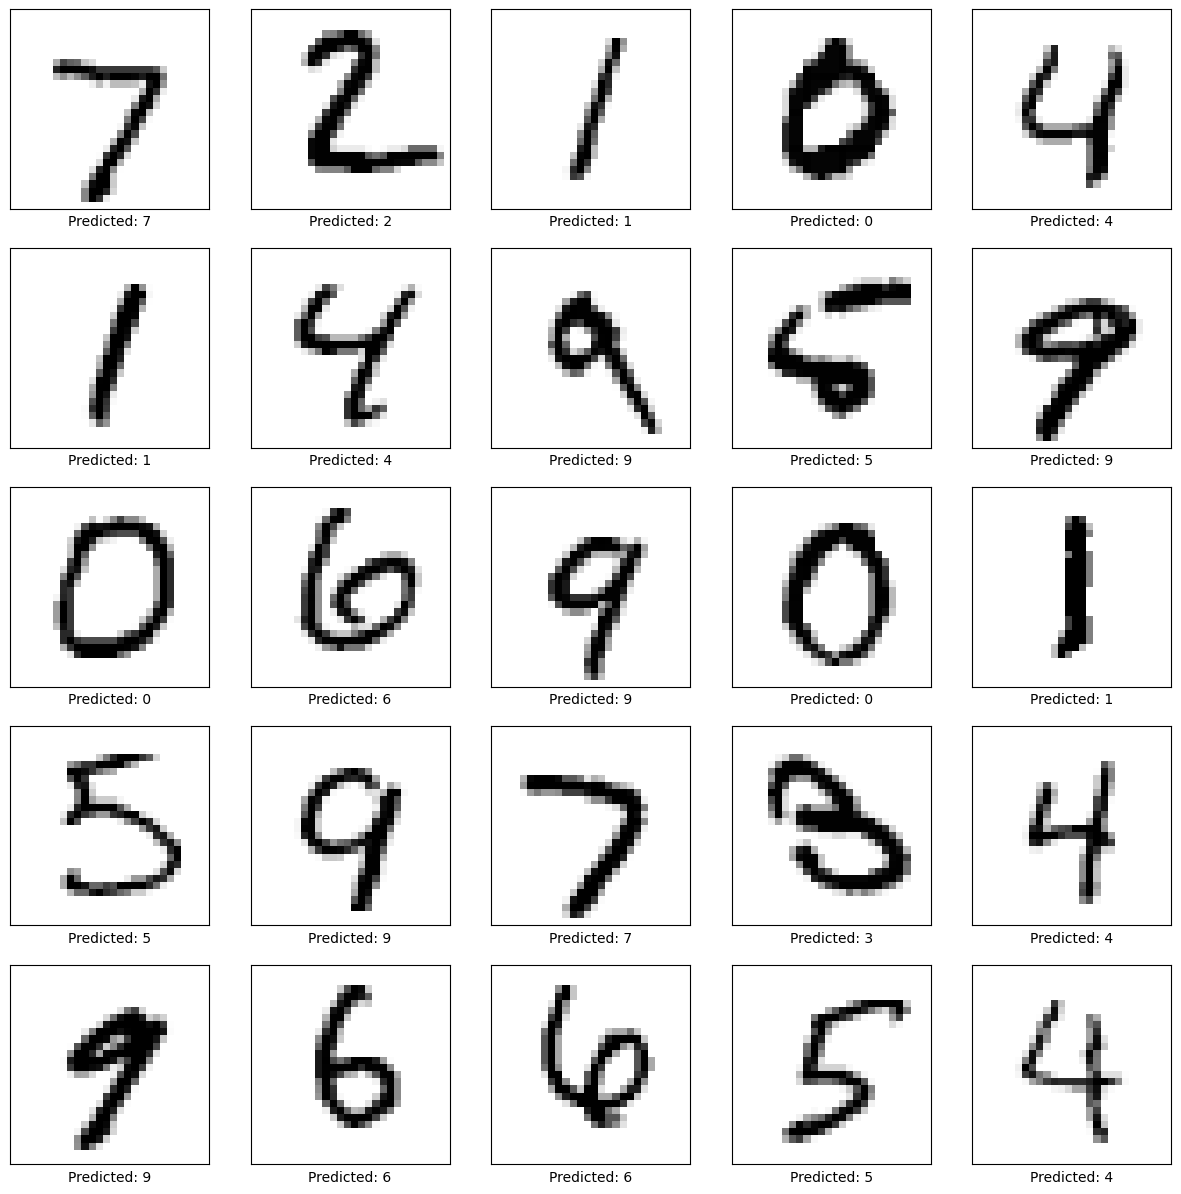

In [39]:
predicted_labels = model.predict(X_test)
predicted_labels = np.argmax(predicted_labels, axis=1)
display_image_predictions(X_test, y_test, predicted_labels, num_images=25)